# Produce synthetic discrete gaussian data

In [1]:
import sys
sys.path.append("../src/")

import numpy as np

import matplotlib.pyplot as plt

from mask import simulate_mask
from plotting import plot_profile, plot_hmap
from splitting import train_val_split

from dgd_data_generator import (
    simulate_float_from_named_basis,
    simulate_dgd
)

%matplotlib inline

In [11]:
SEED = 42

# Location where data matrix and masks will be stored.
PATH_TO_DATA = "/Users/sela/Desktop/recsys/data/gd_data/100p/"

# To truncate profiles at empirical dropout times. The file contains a probbaility 
# vector where each entry of the vector holds a  probability that the female will never be 
# screened again.
PATH_TO_DROPOUT = '/Users/sela/phd/data/real/Pdropout_2Krandom.npy'

# Synthesize complete profiles

In [3]:
M = simulate_float_from_named_basis(
    basis_name='simple_peaks', 
    N=38000, 
    T=321, 
    K=5, 
    domain=[1, 4], 
    random_state=SEED
)

D = simulate_dgd(
    M, 
    domain_z=np.arange(1, 5),
    theta=2.5,
    random_state=SEED
)

# Sparsening

In [14]:
# Mask level per training density
# * 100%: Skip mask.
# * 80%: 3.5 
# * 50%: 2.1 (NB: Set N = 38020 since some rows are all-zero.)
# * 20%: 1.1 (NB: Set N = 38400 since some rows are all-zero.)
# * 10%: 0.7 (NB: Set N = 40100 since some rows are all-zero.)
# * 5%: 
# * 3%: 

mask = simulate_mask(
    D,
    screening_proba=np.array([0.05, 0.15, 0.40, 0.60, 0.20]),
    memory_length=10,
    level=3.5,
    path_dropout=PATH_TO_DROPOUT,
    random_state=SEED
)

# NOTE: Skip mask for 100 %.
X = D * mask

# Training and validation sets

In [15]:
def profile_density(Z):
    
    densities = 0
    for num, row in enumerate(Z):
    
        z_tr = row[:np.argmax(np.cumsum(row))]
    
        densities += np.count_nonzero(z_tr) / z_tr.size
    
    # Average matrix density wrt. profiles.
    print(densities / (num + 1))

In [16]:
prediction_window = 4

O_train, O_val, valid_rows = train_val_split(X, prediction_window, method='last_observed', return_valid_rows=True,
                                             seed=SEED)

Dv = D[valid_rows, :]
Xv = X[valid_rows, :]
Ov_val = O_val[valid_rows, :]
Ov_train = O_train[valid_rows, :]

print(np.shape(X))

X_val = Xv * Ov_val
X_train = Xv * Ov_train

# NB: Compute density of only profiles and not the complete matrix.
profile_density(X_train)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 37998 but corresponding boolean dimension is 38000

# Inspect

In [ ]:
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for num, axis in enumerate(axes.ravel()):
    
    # Add plot to figure.
    plot_profile(X_train[num], axis, show=False, label='Training')
    plot_profile(X_val[num], axis, show=False, label='Validation')
    
    axis.legend()

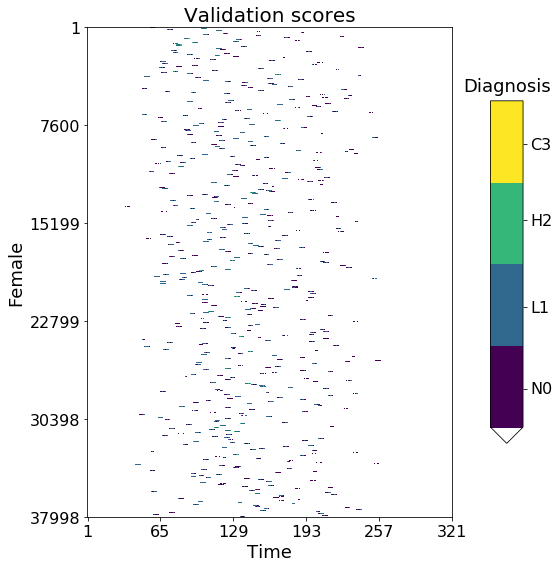

States: [1. 2. 3. 4.]
Counts: [78899 89259  4887    55]
Number of all-zero profiles: 0


In [17]:
fig = plt.figure(figsize=(8, 8))
plt.title("Validation scores", fontsize=20)
plot_hmap(fig, X_val)

vals, cnts = np.unique(X_val[X_val != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_val, axis=1) == 0))))

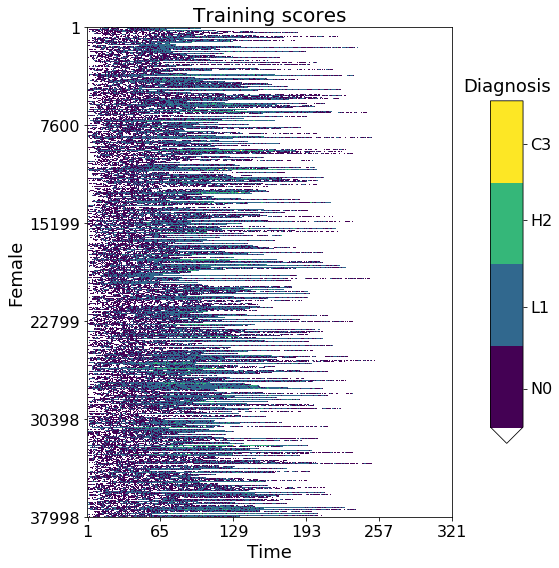

States: [1. 2. 3. 4.]
Counts: [2132524 2075657   99255    1089]
Number of all-zero profiles: 0


In [18]:
fig = plt.figure(figsize=(8, 8))
plt.title("Training scores", fontsize=20)
plot_hmap(fig, X_train)

vals, cnts = np.unique(X_train[X_train != 0], return_counts=True)
print('States:', vals)
print('Counts:', cnts)

# Sanity check.
print('Number of all-zero profiles:', len(np.squeeze(np.where(np.sum(X_train, axis=1) == 0))))

# Save data to disk

In [19]:
np.save(f'{PATH_TO_DATA}/M.npy', Mv)
np.save(f'{PATH_TO_DATA}/X.npy', Xv)
np.save(f'{PATH_TO_DATA}/O_val.npy', Ov_val)
np.save(f'{PATH_TO_DATA}/O_train.npy', Ov_train)